In [9]:
pip install gitpython


Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

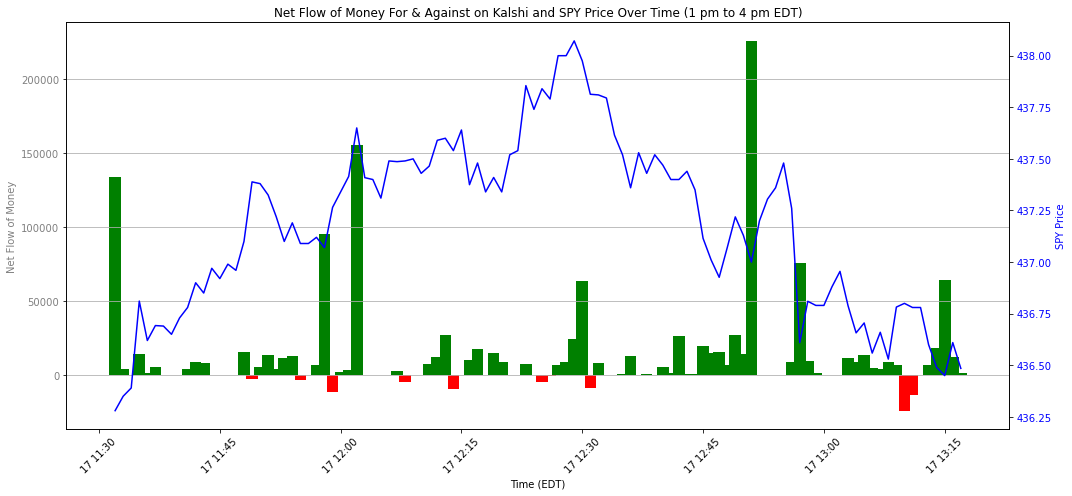

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

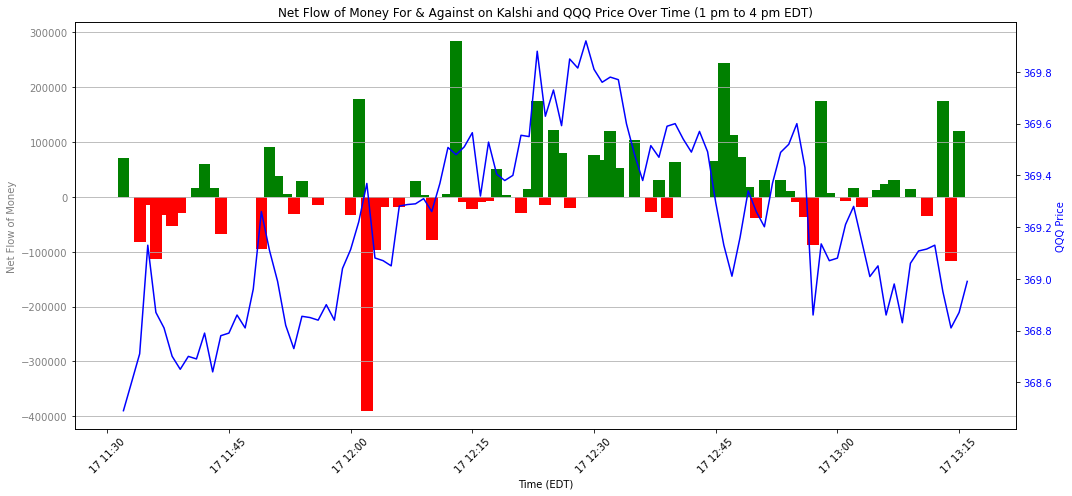

In [28]:
# Load datasets
from datetime import datetime, timedelta, timezone
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
trades_df = pd.read_csv(r"C:\Users\w7car\kalshi_test.csv")



def kalshi(tick, tick1):
    sd = datetime(2023, 10, 17)
    ed = datetime(2023, 10, 18)
    df = yf.download(tickers=tick1, start=sd, end=ed, interval="1m")
    df.to_csv('yf.csv')
    provided_stock_data = pd.read_csv(r"C:\Users\w7car\yf.csv", parse_dates=[0], index_col=0)


    # Process the trades data
    trades_df['Date'] = trades_df['ticker'].str.extract('(\d{2}[A-Z]{3}\d{2})')
    trades_df['Trade_Price'] = trades_df['ticker'].str.extract('(\d+)$').astype(float) / 100
    target_df = trades_df[(trades_df['ticker'].str.contains(tick)) & (trades_df['Date'] == '23OCT17')]

    # Adjust 'created_time' column and add 'Stock' column
    target_df['created_time'] = pd.to_datetime(target_df['created_time'])
    target_df['Stock'] = tick1

    # Convert the timezone of provided_stock_data's index to US/Eastern
    provided_stock_data.index = provided_stock_data.index.tz_convert('US/Eastern')

    # Handle timezone conversion for target_df
    if target_df['created_time'].dt.tz:
        target_df['created_time'] = target_df['created_time'].dt.tz_convert('US/Eastern')
    else:
        target_df['created_time'] = target_df['created_time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

    # Merge with the provided stock data
    target_df = target_df.merge(provided_stock_data[['Close']].rename(columns={'Close': 'Stock_Price'}), left_on='created_time', right_index=True, how='left')
    target_df['Stock_Price'].fillna(method='ffill', inplace=True)

    # Classify the bet type and calculate dollar quantity
    def classify_bet(row):
        if row['taker_side'] == 'yes':
            return 'for' if row['Trade_Price'] > row['yes_price'] else 'against'
        else:
            return 'against' if row['Trade_Price'] > row['no_price'] else 'for'

    target_df['Bet_Type'] = target_df.apply(classify_bet, axis=1)

    target_df['Dollar_Quantity'] = target_df['count'] * target_df['Trade_Price']

    # Calculate net flow based on Bet_Type
    net_flow = target_df.groupby('created_time').apply(lambda x: x.loc[x['Bet_Type'] == 'for', 'Dollar_Quantity'].sum() - x.loc[x['Bet_Type'] == 'against', 'Dollar_Quantity'].sum())

    # Resample net flow to minute-level granularity
    net_flow_resampled = net_flow.resample('T').sum()

    # Filter for trades between 1 pm and 4 pm Eastern Time
    net_flow_resampled = net_flow_resampled.between_time('11:00:00', '16:00:00')

    # Visualization
    bar_colors = ['green' if value > 0 else 'red' for value in net_flow_resampled]

    fig, ax1 = plt.subplots(figsize=(15, 7))
    bars = ax1.bar(net_flow_resampled.index, net_flow_resampled, color=bar_colors, width=0.001, label='Net Flow')
    ax1.set_xlabel('Time (EDT)')
    ax1.set_ylabel('Net Flow of Money', color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')
    ax1.grid(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(net_flow_resampled.index, provided_stock_data.loc[net_flow_resampled.index, 'Close'], color='blue', label=tick1+' Price')
    ax2.set_ylabel(tick1+' Price', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax1.set_title('Net Flow of Money For & Against on Kalshi and '+tick1+' Price Over Time (1 pm to 4 pm EDT)')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

# Execute the kalshi function for 'NASDAQ' corresponding to the 'QQQ' stock
kalshi('INXD','SPY')
kalshi('NASDAQ','QQQ')



[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

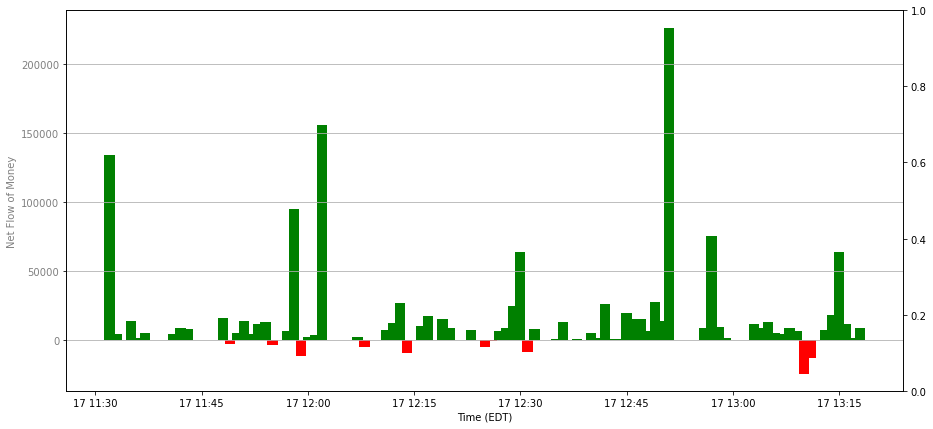

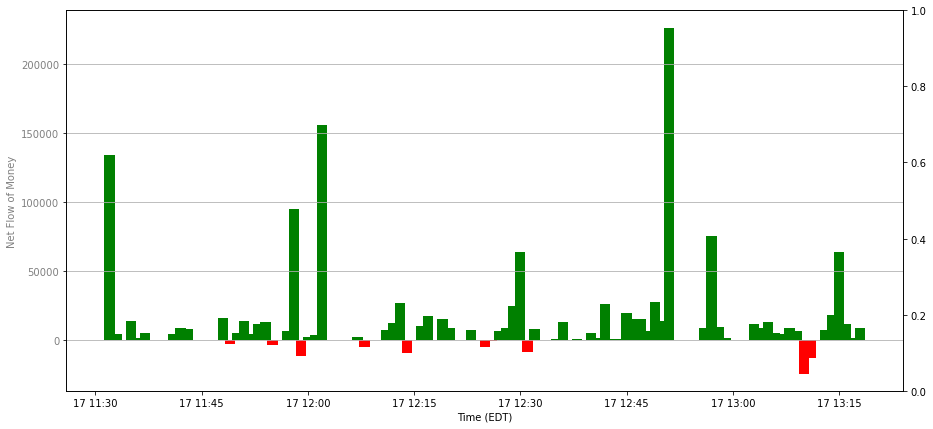

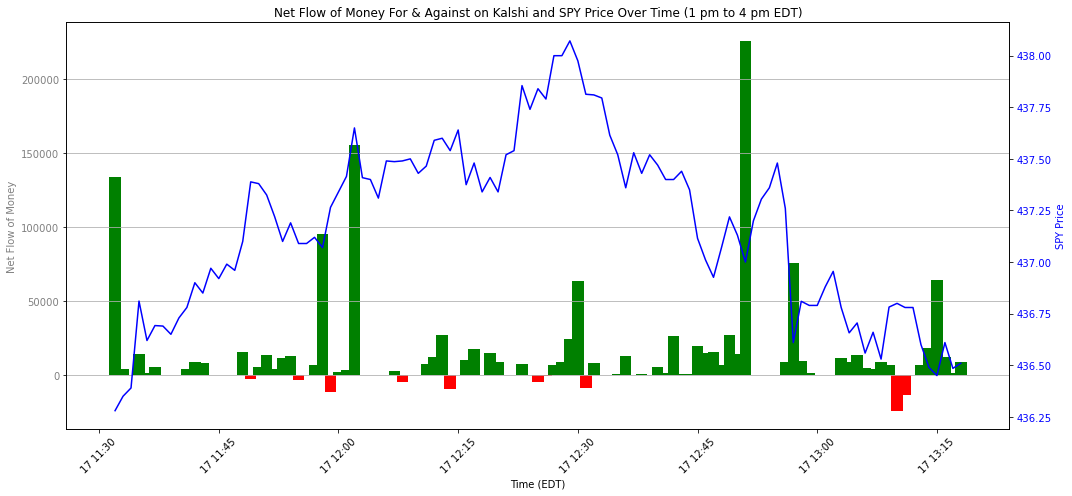

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

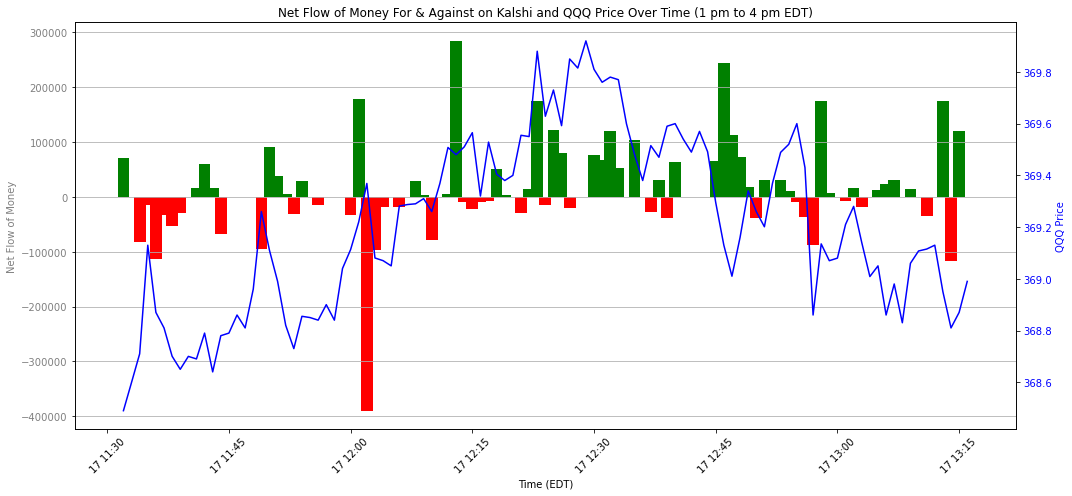

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

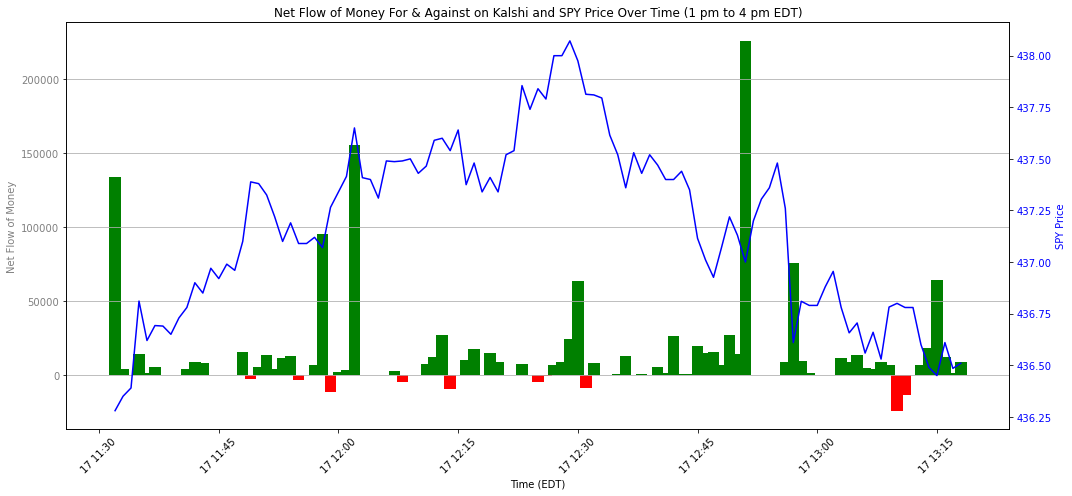

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

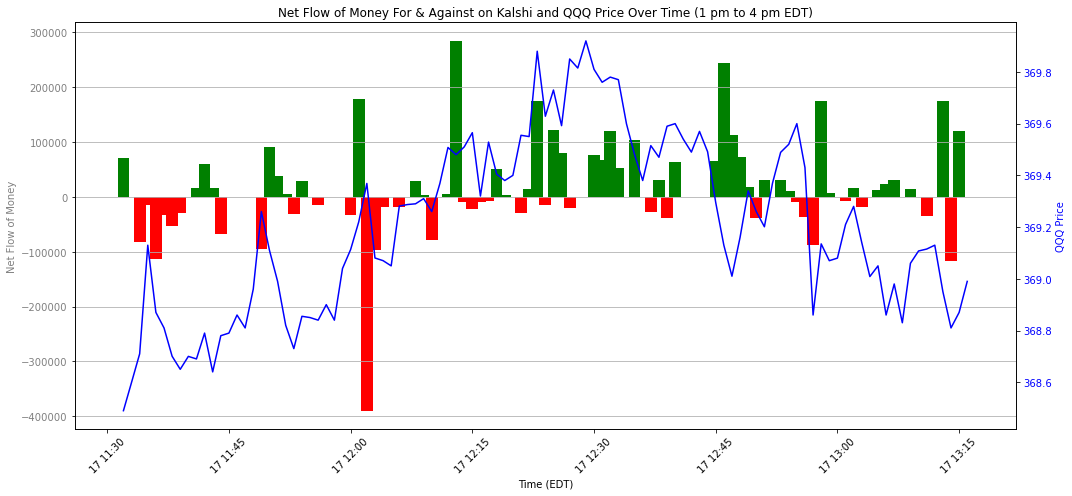

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

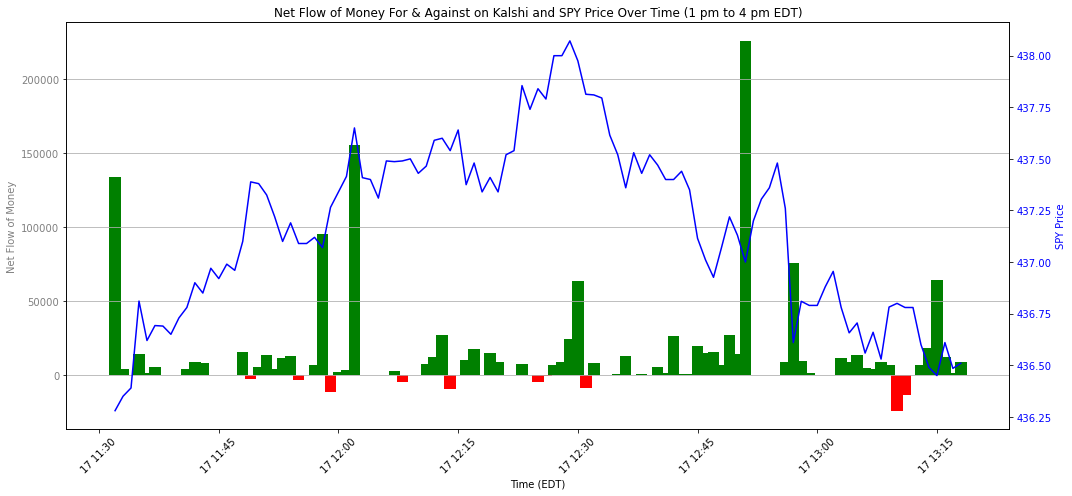

[*********************100%***********************]  1 of 1 completed


C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['created_time'] = pd.to_datetime(target_df['created_time'])
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Stock'] = tick1
C:\Users\w7car\AppData\Local\Temp\ipykernel_27348\2551067551.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

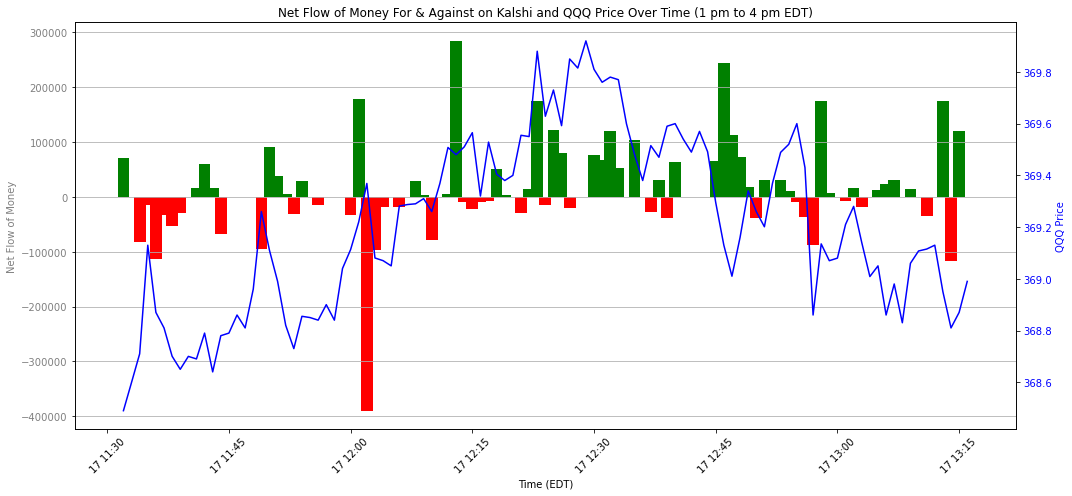

In [ ]:
# Load datasets
from datetime import datetime, timedelta, timezone
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import time
import os
from git import Repo

# Setting the path for gitpython to recognize the git executable
os.environ['GIT_PYTHON_GIT_EXECUTABLE'] = r"C:\Program Files\Git\cmd\git.exe"

trades_df = pd.read_csv(r"C:\Users\w7car\kalshi_test.csv")

REPO_PATH = r'C:\Users\w7car\Documents\kalshi_live'


def update_and_push_to_github():
    """
    Commit changes and push to GitHub.
    Ensure you have set up git credentials or ssh keys in your local repo.
    """
    repo = Repo(REPO_PATH)
    repo.git.add('--all')
    repo.git.commit('-m', 'Automated update of notebook')
    repo.git.push()

    
while True:

    try:
        # Execute the kalshi function for 'NASDAQ' corresponding to the 'QQQ' stock
        kalshi('INXD','SPY')
        kalshi('NASDAQ','QQQ')

        update_and_push_to_github()
        time.sleep(60)

        # Wait for 60 seconds before next iteration
    except:
        time.sleep(15)